# California Price prediction

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# documentation about california housing dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html


from sklearn.datasets import fetch_california_housing


dataset = fetch_california_housing()


x_full, y_full = dataset.data, dataset.target


dc_listings = pd.DataFrame(x_full, columns=dataset.feature_names)
dc_listings['price'] = y_full


one_hot_features = []
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target = 'price'

# make all one hot features strings
for feature in one_hot_features:
    dc_listings[feature] = dc_listings[feature].astype(str)


# make all features a float
for feature in features + [target]:
    if feature not in one_hot_features:
        dc_listings[feature] = dc_listings[feature].astype(float)

dc_listings[features + [target]].describe()

# perform one hot encoding
for feature in one_hot_features: 
    one_hot_enc = OneHotEncoder(categories='auto')   
    one_hot_encoded = one_hot_enc.fit_transform(dc_listings[f'{feature}'].values.reshape(-1,1)).toarray()
    
    # convert back to data frame
    df_one_hot = pd.DataFrame(one_hot_encoded, columns = [f"{feature}_"+str(int(i)) for i in range(one_hot_encoded.shape[1])])
    dc_listings = pd.concat([dc_listings, df_one_hot], axis=1)
    features.extend([f"{feature}_"+str(int(i)) for i in range(one_hot_encoded.shape[1])])
    
# drop any NaN values
dc_listings = dc_listings.dropna(subset=features + [target])
dc_listings.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


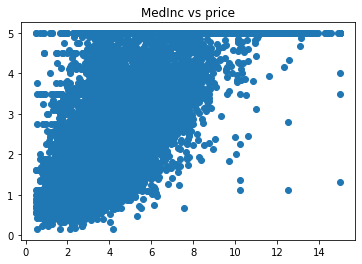

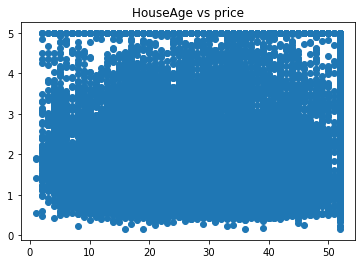

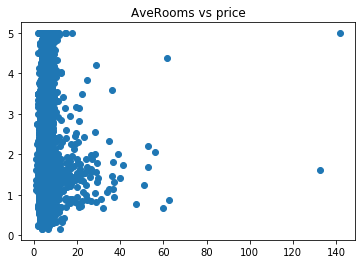

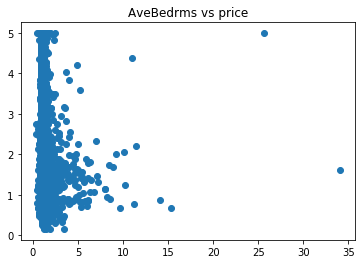

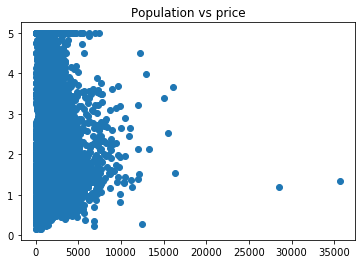

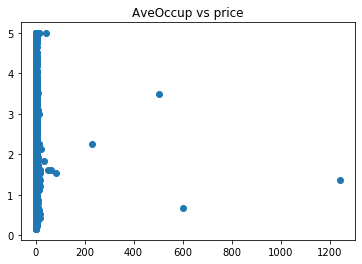

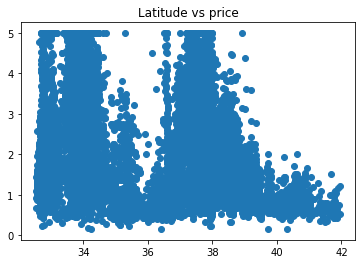

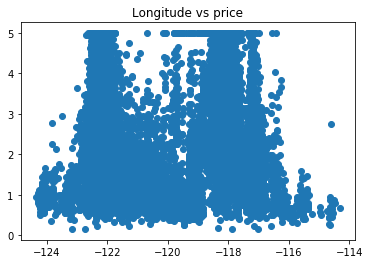

In [3]:
# Plot some data
for f in ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']:
    plt.scatter(dc_listings[f], dc_listings[target])
    plt.title(f'{f} vs {target}')
    plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# Split into test and training set
train, test = train_test_split(dc_listings, test_size=0.2)

# normalize the data in the columns
feature_train = train[features]
target_train = train[target]
feature_test = test[features]
target_test = test[target]

# learn scalers
feature_scaler = RobustScaler(quantile_range=(25, 75)).fit(feature_train)

# perform scaling
feature_train = feature_scaler.transform(feature_train)
feature_test = feature_scaler.transform(feature_test)

In [5]:
#from sklearn.neighbors import KNeighborsRegressor
#model = KNeighborsRegressor()
#model.fit(feature_train, target_train)

#from sklearn.linear_model import LinearRegression
#model = LinearRegression()
#model.fit(feature_train, target_train)

from sklearn import ensemble
model = ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='ls')
model.fit(feature_train, target_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# Evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(target_test, model.predict(feature_test)) ** (1/2)
print(f'RMSE: {mse}')

print(f'Score: {model.score(feature_test, target_test)}')

RMSE: 0.4589087288497312
Score: 0.8392800016496852
